In [ ]:
 import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# Загрузка датасета Malaria
dataset_name = 'malaria'
dataset, info = tfds.load(dataset_name, split='train', with_info=True)

# Разделение на тренировочную и валидационную части
num_samples = info.splits['train'].num_examples
train_size = int(0.8 * num_samples)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

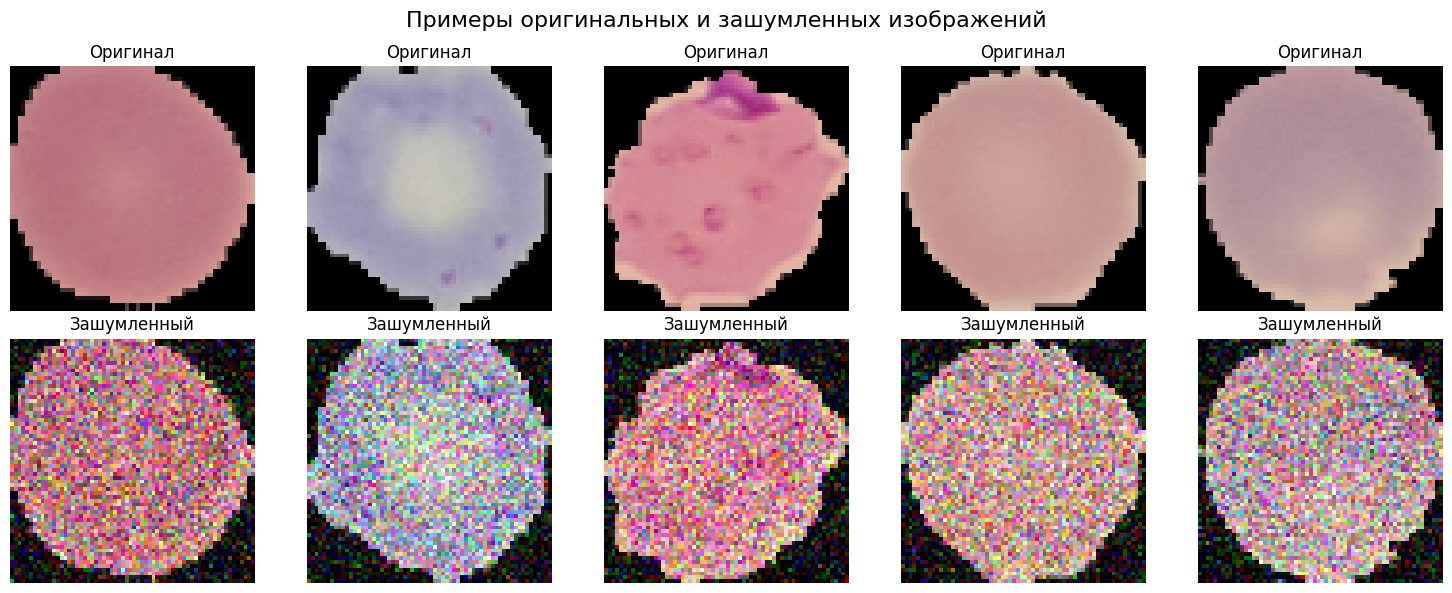

In [ ]:
def add_noise(image, noise_factor=0.2):
    noisy_image = image + noise_factor * tf.random.normal(shape=tf.shape(image), dtype=tf.float32)
    noisy_image = tf.clip_by_value(noisy_image, 0., 1.)
    return noisy_image

# Вывод 5 примеров оригинальных изображений и их шумов
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Примеры оригинальных и зашумленных изображений', fontsize=16)

for i, example in enumerate(train_dataset.take(5)):
    original_image = tf.image.resize(example['image'], (64, 64)) / 255.0  # Изменение размера и нормализация
    noisy_image = add_noise(original_image)

    axs[0, i].imshow(original_image)
    axs[0, i].axis('off')
    axs[0, i].set_title('Оригинал')

    axs[1, i].imshow(noisy_image)
    axs[1, i].axis('off')
    axs[1, i].set_title('Зашумленный')

plt.tight_layout()
plt.show()

In [ ]:
def denoising_autoencoder():
    input_img = tf.keras.layers.Input(shape=(64, 64, 3))
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = tf.keras.models.Model(input_img, decoded)
    return autoencoder

model = denoising_autoencoder()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 8)         1160      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 8)         584 

In [ ]:
# Подготовка данных для обучения и валидации
train_data_clean = np.stack([tf.image.resize(example['image'], (64, 64)) / 255.0 for example in train_dataset])
train_data_noisy = np.stack([add_noise(image) for image in train_data_clean])

val_data_clean = np.stack([tf.image.resize(example['image'], (64, 64)) / 255.0 for example in val_dataset])
val_data_noisy = np.stack([add_noise(image) for image in val_data_clean])

In [ ]:
# Компиляция и обучение модели
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit(train_data_noisy,
                    train_data_clean,
                    validation_data=(val_data_noisy, val_data_clean),
                    epochs=10,
                    batch_size=128,
                    shuffle=True)

Epoch 1/10
173/173 [==============================] - 18s 30ms/step - loss: 0.0265 - accuracy: 0.5952 - val_loss: 0.0095 - val_accuracy: 0.5439
Epoch 2/10
173/173 [==============================] - 4s 22ms/step - loss: 0.0077 - accuracy: 0.5950 - val_loss: 0.0067 - val_accuracy: 0.6688
Epoch 3/10
173/173 [==============================] - 4s 24ms/step - loss: 0.0060 - accuracy: 0.6807 - val_loss: 0.0054 - val_accuracy: 0.6962
Epoch 4/10
173/173 [==============================] - 4s 21ms/step - loss: 0.0051 - accuracy: 0.6974 - val_loss: 0.0049 - val_accuracy: 0.7034
Epoch 5/10
173/173 [==============================] - 4s 21ms/step - loss: 0.0047 - accuracy: 0.7013 - val_loss: 0.0046 - val_accuracy: 0.7048
Epoch 6/10
173/173 [==============================] - 4s 24ms/step - loss: 0.0044 - accuracy: 0.7011 - val_loss: 0.0043 - val_accuracy: 0.7026
Epoch 7/10
173/173 [==============================] - 4s 23ms/step - loss: 0.0042 - accuracy: 0.6967 - val_loss: 0.0041 - val_accuracy: 0.693

In [ ]:
model.save('malaria_model.h5')

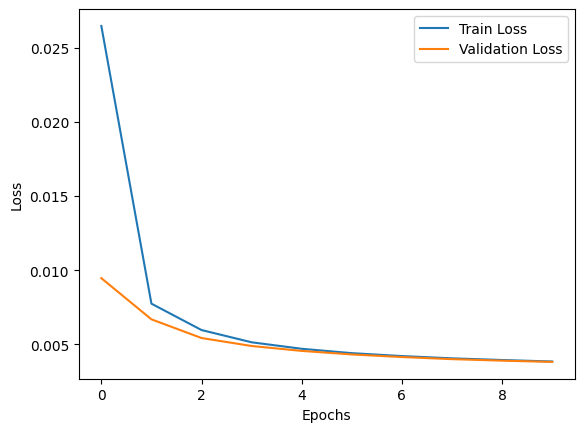

In [ ]:
# Вывод графика функции потерь
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

1/1 [==============================] - 0s 75ms/step


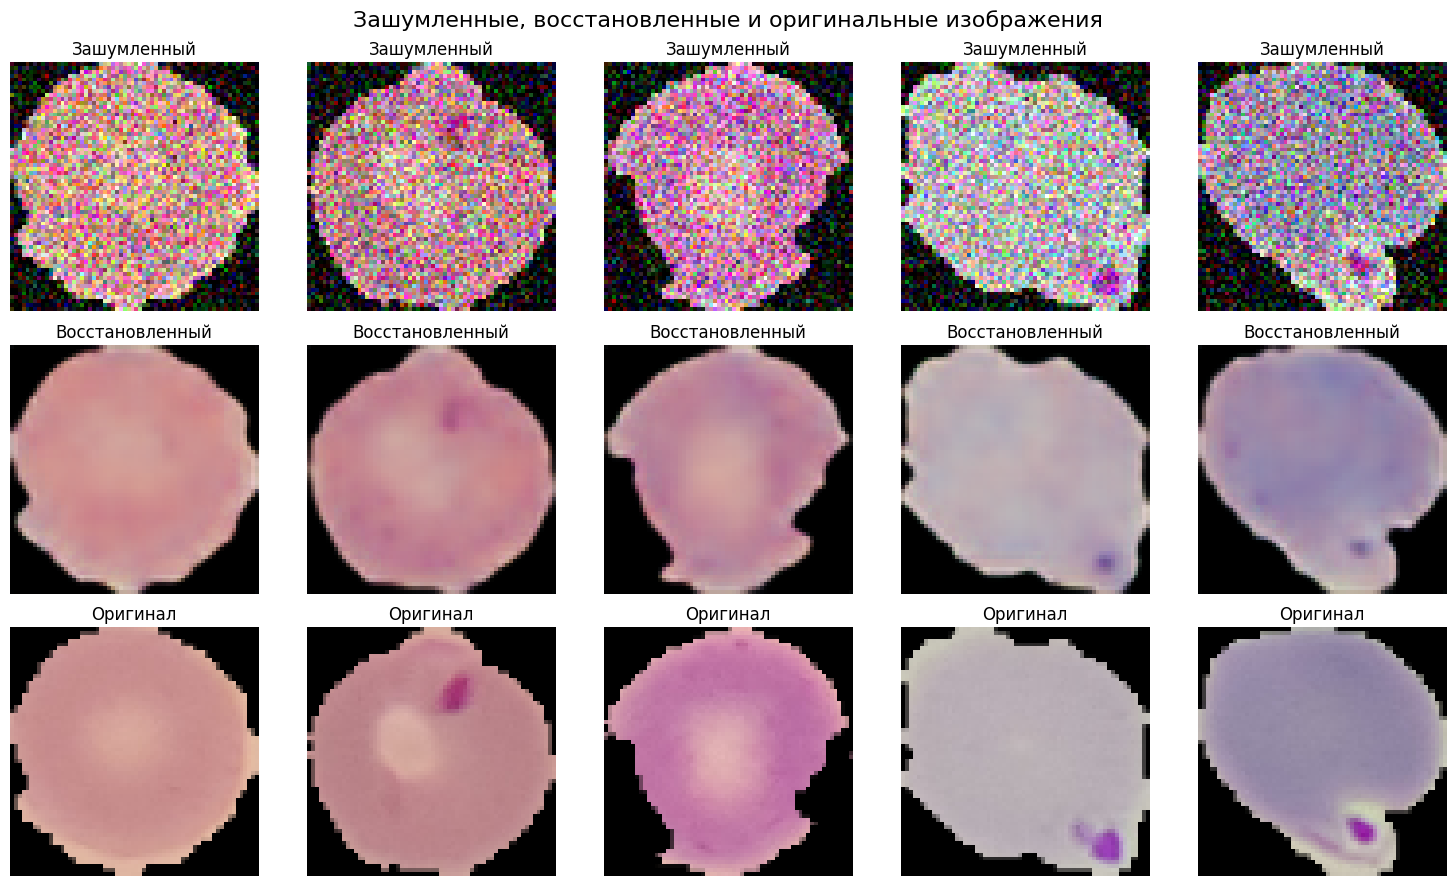

In [ ]:
# Выбор случайных примеров из валидационного датасета
random_val_indices = np.random.choice(len(val_dataset), size=5, replace=False)
random_val_data = val_data_noisy[random_val_indices]

model = tf.keras.models.load_model('malaria_model.h5')

# Получение восстановленных изображений с помощью модели
reconstructed_images = model.predict(random_val_data)

# Вывод зашумленных, восстановленных и оригинальных изображений
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.suptitle('Зашумленные, восстановленные и оригинальные изображения', fontsize=16)

for i, index in enumerate(random_val_indices):
    noisy_image = random_val_data[i]
    reconstructed_image = reconstructed_images[i]
    original_image = val_data_clean[index]

    axs[0, i].imshow(noisy_image)
    axs[0, i].axis('off')
    axs[0, i].set_title('Зашумленный')

    axs[1, i].imshow(reconstructed_image)
    axs[1, i].axis('off')
    axs[1, i].set_title('Восстановленный')

    axs[2, i].imshow(original_image)
    axs[2, i].axis('off')
    axs[2, i].set_title('Оригинал')

plt.tight_layout()
plt.show()
